In [11]:
import math
import numpy as np
from pyedflib import highlevel
import matplotlib.pyplot as plt
from utils import freq_feats, nextpow2, hjorth_parameters
from scipy.stats import skew, kurtosis

## EEG Signals

- 64 Channels described on `signal_headers` (sample rate, dimension and DAC gain.)
- 109 volunteers
- 1500 One and two minute recordings.

In [12]:
sample_rate = 160.0

In [13]:
def read_edf_file(path: str):
    signals, signal_headers, header = highlevel.read_edf(path)
    annotations = header["annotations"]
    channels_labels = [i["label"] for i in signal_headers]
    return signals, annotations, channels_labels

def plot_time_signal(t: np.ndarray, signal: np.ndarray, channel: str) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(24, 6))
    ax.plot(t, signal)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(channel)
    ax.grid(True)
    
def get_time_vector(signal: np.ndarray):
    t = np.arange(0, len(signal) / 160.0, (1 / 160.0))
    return t

def file_names_generator(subject_number: int):
    tasks_number = 14
    file_names = [f"S{subject_number:03}R{i:02}.edf" for i in range(1, tasks_number + 1)]
    return file_names
    

In [14]:
subject_number = 1
file_names = file_names_generator(subject_number)

In [15]:
channel_index = 0
file_index = 1
signals, annotations, channels_labels = read_edf_file(f"../data/files/eegmmidb/1.0.0/S001/{file_names[file_index]}")
t = get_time_vector(signals[channel_index])
y = signals[channel_index, :]

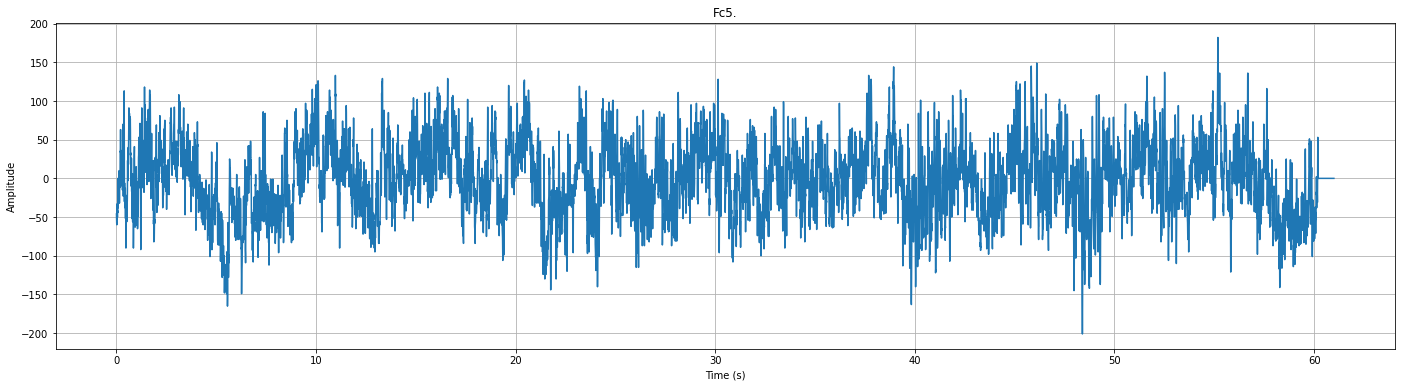

In [16]:
plot_time_signal(t, y, channels_labels[channel_index])

## TODO
- Init a repo and push to github
- Start adding precommit hooks
    - Linter
    - Formatter
    - JSON
    - YAML
- Define the task
    - Want to detect where is the beggining and end?
    - Want to classify a segment as certain task? or the whole signal?
- Choose a subset of subjects (could be 20)
- Reduce the number of channels using dimensionality reduction methods
    - Research about cortex/brain areas related to motor
        - https://www.researchgate.net/publication/321394237_Classification_of_Motor_Imagery_Based_EEG_Signals_Using_Sparsity_Approach
    - PCA
    - 
- Segment signals in different tasks according to annotations
- Develop various feature extraction pipelines
    - In time domain
    - In frequency domain
    - Extract spectrogram and image based features
- Review dataset balance after segmentation
- Check which models are better to identify the parts of interest
    - Convolutional neural network
    - LSTM neural network
    - XGBoost classifier

In [17]:
win_size = int(10 * sample_rate)
win_over = win_size * 0.75
psd_win = 1024
psd_over = 0.5
nfft = nextpow2(signals.shape[1])
freq_lims = [0, 80]
length = signals.shape[1]
step = int(win_size - win_over) # step length
nwins = math.floor((length - win_over) / step) # number of windows
nchann = signals.shape[0]
# initialization
m_powdelta: np.ndarray = np.zeros((nwins, nchann))
m_powtheta: np.ndarray = np.zeros((nwins, nchann))
m_powalpha: np.ndarray = np.zeros((nwins, nchann))
m_powbeta: np.ndarray = np.zeros((nwins, nchann))
m_powlowgamma: np.ndarray = np.zeros((nwins, nchann))
for n in range(0, nchann):
    powdelta, powtheta, powalpha, powbeta, powlowgamma = freq_feats(
        signals.T[:, 0],
        win_size, 
        win_over,
        psd_win,
        psd_over,
        nfft,
        sample_rate,
        freq_lims
    )
    m_powdelta[:, n] = powdelta
    m_powtheta[:, n] = powtheta
    m_powalpha[:, n] = powalpha
    m_powbeta[:, n] = powbeta
    m_powlowgamma[:, n] = powlowgamma

In [42]:
def temp_feats(signal: np.ndarray, winsize: int, winoverlap: int):
        
    length = signal.shape[0]
    step = int(winsize - winoverlap) # step length
    nwins = math.floor((length - winoverlap) / step) # number of windows
    chann = signal.shape[1]
    
    # variables init
    mu = np.zeros((nwins, chann))
    sigma = np.zeros((nwins, chann))
    sk = np.zeros((nwins, chann))
    kurt = np.zeros((nwins, chann))
    
    act = np.zeros((nwins, chann))
    mob = np.zeros((nwins, chann))
    comp = np.zeros((nwins, chann))
    
    # counters inits
    wincount = 0
    index = 0
    
    while (wincount < nwins):
        # Window movement and extraction
        win_signal = signal[index:index+winsize, :]        
        # mean, variance, skewness and kurtosis
        mu[wincount, :] = np.mean(win_signal)
        sigma[wincount, :] = np.var(win_signal)
        sk[wincount, :] = skew(win_signal, axis=0)
        kurt[wincount, :] = kurtosis(win_signal, axis=0)
        
        # Hjörth Parameters
        [v_act, v_mob, v_comp] = hjorth_parameters(win_signal)
        act[wincount, :] = v_act
        mob[wincount, :] = v_mob
        comp[wincount, :] = v_comp
        
        index += step        
        wincount += 1
    return mu, sigma, sk, kurt, act, mob, comp

In [43]:
win_size = int(10 * sample_rate)
win_over = win_size * 0.75
mu, sigma, sk, kurt, act, mob, comp = temp_feats(signals.T, win_size, win_over)

(64, 9760)